In this file, we clean up the data scraped from apartments.com.

In the scraper, we didn't include a lot of data validation logic. Plyaing around with it, we see a few issues:

- Some rows have more columns than others. This is from a bug that splits some prices that have commas in them.
- Some rental prices are in a range, such as "$1520 - $1600"
- Some studios are listed as "0" bedrooms, while others are listed as "Studio" bedrooms
- Some rows are missing data

Let's clean all this up, and extract some more useful features from the data.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from functools import reduce
import re 
from collections import defaultdict

import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import pandas as pd

DIR = '/home/bryce/Projects/Data_Science/Apt_Prices/'

In [2]:
results_file = '/home/bryce/Projects/Data_Science/Apt_Prices/all-results.csv'

adjusted_lines = []

with open(results_file, 'r') as f:
    for line in f.readlines():
        columns = line.split(';;')
        if len(columns) > 5:
            extra_cols = columns[4:]
            new_col = reduce(lambda s1, s2: s1.strip() + s2.strip(), extra_cols)
            new_cols = columns[:4] + [new_col]
            new_line = ';; '.join(new_cols)
            adjusted_lines.append(new_line + '\n')
            continue
        elif len(columns) <= 2:
            # these are either blank lines or the couple lines where an address wasn't found
            continue
        adjusted_lines.append(line)

adjusted_results_file = '/home/bryce/Projects/Data_Science/Apt_Prices/cleaned-results.csv'
with open(adjusted_results_file, 'w') as outfile:
    outfile.writelines(adjusted_lines)

OK, so the number of rows is consistent!

But we can't do regression can't on '$2345' and '2 bds' and whatnot.

So let's clean up the file further.

old file columns:

123 Main St, Charleston, SC, 20401 - Downtown;; $2131;; 2 bd;; 1 ba;; 1,200 sq ft

the new file columns:

123 Main St, Charleston, SC 29401; Downtown; 2; 1; 1200; 2131

In [3]:
adjusted_results_file = '/home/bryce/Projects/Data_Science/Apt_Prices/cleaned-results.csv'
df = pd.read_csv(adjusted_results_file, delimiter=';;', names = ['address', 'price', 'beds', 'baths', 'sq_ft'], engine='python')
print(df.columns)

SKIP = -1

# Some apartment's prices on apartments.com are of the form "$1400 – $1520"
# This function will return the average of the two prices, if the difference
# in price is <= max_range. Otherwise, it returns SKIP
def replace_price_range_with_average(pr_str, max_range):
    # eliminate spaces and commas
    pr_s = pr_str.replace(' ', '').replace(',', '')
    # replace multiple dollar signs with one
    pr_s = re.sub(r'\$+', '$', pr_s)
    # get the two prices
    m = re.match(r'.*\$([0-9]+)–\$([0-9]+)', pr_s)
    if m is None:
        print("Unexpected price string: ", pr_str)
        return SKIP
    (p1, p2) = m.groups(0)
    pr1 = int(p1)
    pr2 = int(p2)
    diff = pr2 - pr1
    assert diff >= 0, "Negative price range"
    if diff <= max_range:
        return pr1 + math.floor(diff / 2)
    else:
        return SKIP
    
def clean_price(pr_str):
    pr_arr = pr_str.split()
    if len(pr_arr) > 1:
        return replace_price_range_with_average(pr_str, 80)
    price = re.sub(r'\$|,', '', pr_arr[0]).strip()
    return price


def get_first_word_as_number(string, expected_num_words):
    arr = string.split()
    if len(arr) != expected_num_words:
        print("Expected " + str(expected_num_words) + " words in this string: ", string)
        return SKIP
    result = re.sub(r',', '', arr[0].strip())
    return result





addr_and_part_of_town = df['address'].str.split('–', 1, expand=True)
df['address'] = addr_and_part_of_town[0].map(lambda s : s.strip())
df['location'] = addr_and_part_of_town[1].map(lambda s : s.strip() if s else s)  # the if statement handles records with no part of town

df['price'] = df['price'].map(clean_price)
df['beds'] = df['beds'].map(lambda s : get_first_word_as_number(s, 2))
df['baths'] = df['baths'].map(lambda s: get_first_word_as_number(s, 2))
df['sq_ft'] = df['sq_ft'].map(lambda s : get_first_word_as_number(s, 3))

drop_row = (df['price'] == SKIP) | (df['beds'] == SKIP) | (df['baths'] == SKIP) | (df['sq_ft'] == SKIP)
print("We are dropping " + str(drop_row.sum()) + " out of " + str(drop_row.size) + " records.")
df = df[~drop_row]



Index(['address', 'price', 'beds', 'baths', 'sq_ft'], dtype='object')
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpected price string:   $Call for Rent
Unexpe

/tmp/ipykernel_3569/506437733.py:50: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  addr_and_part_of_town = df['address'].str.split('–', 1, expand=True)


Now we're going to extract a couple more features.

We'll save the zip codes and how many units the building has (i.e., how many rows have the same address as the current row)

In [4]:

# First, we'll add zip code as a new column
zips = df['address'].map(lambda s : s.split()[-1])
df['zip'] = zips


# Next, we'll add the number of units per building as a new column
address_count = df['address'].value_counts()
units_in_building = df['address'].map(lambda a : address_count[a])
df['units_in_building'] = units_in_building


# Finally, some studios list their bedroom count as 0, while others say 'Studio'. Let's make this consistent
def handle_studios(s):
    if s.strip().lower() == 'studio':
        return 0
    else:
        return s
    

beds_cleaned = df['beds'].map(handle_studios)
df['beds'] = beds_cleaned

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 1945
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   address            1877 non-null   object
 1   price              1877 non-null   object
 2   beds               1877 non-null   object
 3   baths              1877 non-null   object
 4   sq_ft              1877 non-null   object
 5   location           1877 non-null   object
 6   zip                1877 non-null   object
 7   units_in_building  1877 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 132.0+ KB


OK, so we've cleaned the data and added a couple features. Let's change the datatypes from objects to ints and floats

In [5]:
df['price'] = pd.to_numeric(df['price'])
df['beds'] = pd.to_numeric(df['beds'])
df['baths'] = pd.to_numeric(df['baths'])
df['sq_ft'] = pd.to_numeric(df['sq_ft'])


Let's look up some functions for providing summary statistics, bins, range, etc. for each category

In [6]:
df.describe()
one_beds = df.loc[(df.beds == 1)]
#print(one_beds.describe())


# How many one beds are available in each zip code?
piv = one_beds.pivot_table('price', index='zip', aggfunc='count')
piv = piv.rename(columns={'price': 'count'}).sort_values(by='count', ascending=False)
#print(piv)


# There are the most apartments in 29403 (upper peninsula), 29414 (outer west ashley), 29407 (inner west ashley), and 29492 (daniel island)
# Let's just compare one bedrooms across these zip codes

# What is the average square footage and price per apartment in each of those zip code?
zips_map = {'29403': 'Downtown',
               '29407': 'West Ashley - inner',
               '29414': 'West Ashley - outer',
               '29492': 'Daniel Island'}
obs = one_beds[one_beds['zip'].isin(zips_map.keys())]
def map_zips(row):
    return zips_map[row['zip']]

obs['loc'] = obs.apply(map_zips, axis=1)
obs.drop(columns=['location'])

pr_piv = obs.pivot_table(values=['price', 'sq_ft'], index='loc', aggfunc=['mean', 'count'])

print(pr_piv)


                            mean             count      
                           price       sq_ft price sq_ft
loc                                                     
Daniel Island        1916.026316  806.697368    76    76
Downtown             2848.557312  776.031621   253   253
West Ashley - inner  1636.729167  693.593750    96    96
West Ashley - outer  1627.327586  796.008621   116   116


/tmp/ipykernel_3569/3932437879.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['loc'] = obs.apply(map_zips, axis=1)


Let's plot the square price against square footage for these one bedroom apartments, to see the relationship and the differences across these four parts of town

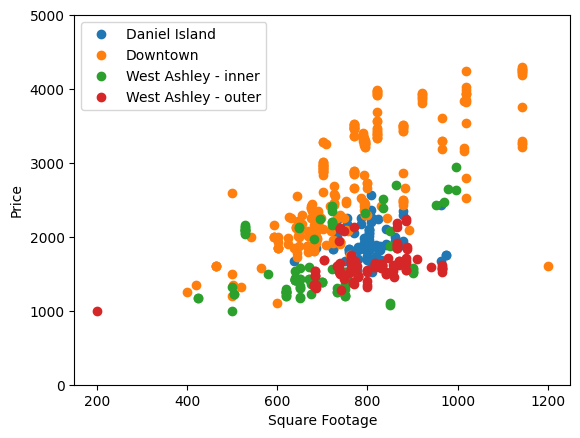

In [7]:
fig, ax = plt.subplots()
groups = obs.groupby('loc')
for loc, group in groups:
    ax.plot(group.sq_ft, group.price, marker='o', linestyle='', label=loc)
ax.legend()
ax.set_xlabel('Square Footage')
ax.set_ylabel('Price')
ax.set_ylim([0,5000])
plt.show()

The above plot seems to show that price per square footage differs in different parts of town. So the zip code categorical variable x square footage would make a good features.

Here's some future data analysis I'd like to do:

- Visualize the prices on a map
- Visualize the square footages on a map

Downtown is interesting, because it is a mixture of old houses and new apartment buildings. Understand the difference in availability between these two types:

- How many 1 bed, 2 bed, 3 bed etc apartments are available for each category
- What square footage range is available in single buildings vs complexes, broken down by number of bedrooms
- Where are apartments of each category located?

In order to map the data, we need each apartment's lat/lng. But we've done some data exploration that shows that a lot of the addresses are "messed up" in some way. Here are the main three ways:

- Duplication: "123 Main Street, 123 Main St, Charleston, SC 29404"
- "Unit"s: "123 Main Street Unit B, Charleston, SC 29404"
- whitespace "             123 Main St, Charleston, SC 29404       "

Let's fix these issues before we try to extract the lat/lngs.

In [9]:
# Here are some functions we use to clean up the addresses.

# This splits the address into three groups. We'll just cut out the 2nd group.
unit_re = r'(.*?)( unit [0-9a-z\.\-\s]+)(,.*)'
unit_comp = re.compile(unit_re)

def remove_unit(addr):
    addr = addr.strip().lower()
    # include groups 1 and 3, but not 2
    cut_addr = unit_comp.sub(r'\1\3', addr)
    cut_addr = cut_addr.title()
    return cut_addr.replace('Sc', 'SC')


name_re = r'[a-z\']+'
word_re = '[a-z]+'
city_re = r'(?:{word} ){{0,2}}{word}'.format(word=word_re)
street_re = '(?:{name} )*{word}'.format(name=name_re, word=word_re)
number_re = '[0-9]+'
spaces_re = r'\s+'
zip_re = '2[0-9]{4}'
address_re = r'{number_re} {street_re}, {city_re}, sc {zip_re}'.format(
    number_re=number_re, street_re=street_re, city_re=city_re, zip_re=zip_re)
search_re = r'.*?({address_re}).*'.format(address_re=address_re)
search_comp = re.compile(search_re)

# Handles the duplication issue.
def extract_address(addr):
    addr = addr.strip().lower()
    m = search_comp.match(addr)
    if m:
        cut_addr = m.groups()[0]
        cut_addr = cut_addr.title()
        return cut_addr.replace('Sc', 'SC')
    else:
        return None

# We do this because technically Daniel Island and Johns Island are in the city of Charleston. The
# lat/lng lookups don't seem to work with these technically inaccurate city names.
def sub_city_names(address):
    if address is None:
        return address
        
    cities_to_sub = {'Daniel Island' : 'Charleston', 'Johns Island' : 'Charleston'}
    for city, sub_city in cities_to_sub.items():
        if city in address:
            return re.sub(city, sub_city, address)
    return address


def clean_address(address):
    addr_without_unit = remove_unit(address)
    extracted_addr = extract_address(addr_without_unit)
    addr_city_subbed = sub_city_names(extracted_addr)
    return addr_city_subbed

So now we get those cleaned up addresses:

In [11]:
df['mapped_address'] = df.address.map(clean_address)

Now let's map these addresses to lat/lng:

In [12]:

import geopy
from geopy.exc import GeocoderUnavailable
from geopy.geocoders import Nominatim
import time


geolocator = Nominatim(user_agent="charleston_apt_prices")
def get_latlng(address):
    try:
        location = geolocator.geocode(address)
        if location:
            latlng = (location.latitude, location.longitude)
            print("Address " + address + " mapped to: ", latlng)
            return latlng
        else:
            print("Couldn't map address: ", address)
            return None
    except GeocoderUnavailable as e:
        time.sleep(10)
        return None


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
unique_addresses = df['mapped_address'].drop_duplicates()
latlngs = unique_addresses.map(get_latlng)
address_to_latlng = pd.Series(latlngs, index = unique_addresses).to_dict()
df['latlng'] = df['mapped_address'].map(lambda addr: address_to_latlng[addr])


# Let's drop the old 'address' column and just keep the new 'mapped_address'
df['address'] = df['mapped_address']
df.drop('mapped_address')

# save these results to CSV:
# dv.to_csv(...)

After looking at the results, it seems that most of the addresses that weren't successfully mapped to a latlng are very small and/or new roads. 

We've gone through the CSV manually and replaced with addresses with nearby larger roads. So let's load the CSV and try to re-map any addresses that don't have a latlng.


In [ ]:
loc_df = pd.read_csv(DIR + 'pandas_output_2-10.csv', sep=';')
addr_to_latlng = pd.Series(loc_df.latlng.values, index=loc_df.address).to_dict()

In [ ]:
geolocator = Nominatim(user_agent="charleston_apt_prices")


def get_existing_or_new_latlng(address):
    if address in addr_to_latlng:
        existing_latlng = addr_to_latlng[address]
        return existing_latlng
    else:
        new_latlng = get_latlng(address)
        # Update the map so that subsequent calls to this address won't have to use geolocator.
        addr_to_latlng[address] = new_latlng
        return new_latlng

loc_df['updated_latlng'] = loc_df['address'].map(get_existing_or_new_latlng)


In [42]:

print("Number of missing latlngs before: ", loc_df.latlng.isna().sum())
print("Number of missing latlngs after updated addresses: ", loc_df.updated_latlng.isna().sum())
print("Percentage of addresses with latlng now: ", 100 * (~loc_df.updated_latlng.isna()).sum() / loc_df.shape[0])


Number of missing latlngs before:  297
Number of missing latlngs after updated addresses:  94
Percentage of addresses with latlng now:  94.99200852424082


We now have the latlngs for about 95% of the listings. This is good enough for me! Let's save these results to a new CSV and we can use that for all subsequent data analysis.

In [43]:
loc_df['latlng'] = loc_df['updated_latlng']
loc_df.drop(columns=['updated_latlng'])
loc_df.to_csv(DIR + 'updated_latlngs.csv', sep=';')